# Introdução

Spam de email ou lixo eletrônico é um tipo de spam que se utiliza o email para o envio de mensagens indesejadas, ou seja, que não foram solicitadas pelo destinatário. Além disso, eles servem como vetor para ataques tipo phishing ou mesmo golpes cada vez mais elaborados por estelionatários. Por dia, estima-se que mais de 100 bilhões de spams são enviados por e-mail.

**O que desejo é classificar o e-mail como spam ou ham com base no seu conteúdo.**

# Sobre os Dados

Link para o database: https://spamassassin.apache.org/old/publiccorpus/

O Spam Assassin Dataset é uma seleção de mensagens de e-mail, adequado para uso em testes de sistemas de filtragem de spam. Este conjunto específico foi obtido do Apache Public Datasets , limpo e organizado em um arquivo csv de uma maneira que possa ser conveniente de usar.

O conjunto de dados é a combinação de ```spam```, ```spam_2```, ```easy_ham``` e ```easy_ham_2```.

Os e-mails de spam:

* O ```spam``` conteúdo continha 500 mensagens de spam, todas recebidas de fontes não spam-trap.
* O ```spam_2``` continha 1397 mensagens de spam. Estes são mais recentes.

Os e-mails não spam: 

* O ```easy_ham``` continha 2500 mensagens não spam. Normalmente, é muito fácil diferenciá-los de spam, pois frequentemente não contêm assinaturas "spam" (como HTML, etc.).
* O ```easy_ham_2``` continha 1400 mensagens não spam. Como spam_2 uma adição mais recente ao conjunto.

# Análise Exploratória de Dados

## Importação das bibliotecas básicas

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

## Base de Dados

In [31]:
base_emails = pd.read_csv('data/spam_assassin.csv')

In [32]:
base_emails

,text,target
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0
...,...,...
5791,From ilug-admin@linux.ie Mon Jul 22 18:12:45 2...,0
5792,From fork-admin@xent.com Mon Oct 7 20:37:02 20...,0
5793,Received: from hq.pro-ns.net (localhost [127.0...,1
5794,From razor-users-admin@lists.sourceforge.net T...,0


O conjunto de dados contém 2 colunas: "Text" que representa o corpo do email e "target" que é sua classificação.

In [33]:
base_emails.describe()

,target
count,5796.000000
mean,0.327122
std,0.469203
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Pela média, percebe-se que a base de dados é desbalanceada, ou seja, há muitos mais emails classifcados como ham do que como spam.

[Text(0, 0, '3900'), Text(0, 0, '1896')]

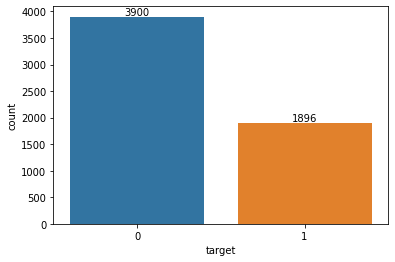

In [34]:
ax = sns.countplot(x = base_emails['target'])
ax.bar_label(container= ax.containers[0], labels = base_emails['target'].value_counts(ascending=False).values)

### Verificando Valores Faltantes

In [35]:
base_emails.isnull().sum()

text      0
target    0
dtype: int64

Perfeito, não há dados faltantes na base de dados.

### Divisão entre Previsores e Classe

In [74]:
X_emails = base_emails.iloc[:, 0].values #text
X_emails[0]

"From ilug-admin@linux.ie Mon Jul 29 11:28:02 2002 Return-Path: <ilug-admin@linux.ie> Delivered-To: yyyy@localhost.netnoteinc.com Received: from localhost (localhost [127.0.0.1]) by phobos.labs.netnoteinc.com (Postfix) with ESMTP id A13D94414F for <jm@localhost>; Mon, 29 Jul 2002 06:25:11 -0400 (EDT) Received: from phobos [127.0.0.1] by localhost with IMAP (fetchmail-5.9.0) for jm@localhost (single-drop); Mon, 29 Jul 2002 11:25:11 +0100 (IST) Received: from lugh.tuatha.org (root@lugh.tuatha.org [194.125.145.45]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g6RHn7i17130 for <jm-ilug@jmason.org>; Sat, 27 Jul 2002 18:49:07 +0100 Received: from lugh (root@localhost [127.0.0.1]) by lugh.tuatha.org (8.9.3/8.9.3) with ESMTP id SAA25016; Sat, 27 Jul 2002 18:45:03 +0100 X-Authentication-Warning: lugh.tuatha.org: Host root@localhost [127.0.0.1] claimed to be lugh Received: from mail1.mail.iol.ie (mail1.mail.iol.ie [194.125.2.192]) by lugh.tuatha.org (8.9.3/8.9.3) with ESMTP id SAA24977 f

In [73]:
y_emails = base_emails.iloc[:, 1].values #target
y_emails[0]

0

### Divisão das bases em treinamento e teste

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_emails_treinamento, X_emails_teste, y_emails_treinamento, y_emails_teste = train_test_split(X_emails, y_emails, test_size = 0.20)

In [40]:
print("Base Total: ", np.shape(base_emails))
print("Base de Treino: ", np.shape(X_emails_treinamento))
print("Base de Teste: ", np.shape(X_emails_teste))

Base Total:  (5796, 2)
Base de Treino:  (4636,)
Base de Teste:  (1160,)


### Limpeza nos Corpos dos Emails

A primeira coisa que devemos fazer ao tratar com o corpo dos emails é retirar as palavras irrelevantes e sem sentido.

Para isso, vamos utilizar a biblioteca ```nltk```, que fornece um conjunto de bibliotecas e programas para processamento simbólico e estatístico de linguagem natural para inglês. O que iremos pegar dela é uma lista de stopwords para removermos dos nossos emails.

Além disso, usaremos o Vetorizador TF-IDF do scikit-learn. Este é um algoritmo muito comum para transformar texto em uma representação significativa de números que é usada para ajustar o algoritmo da máquina para previsão. 

$$TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)$$

* **Term Frequency (TF)** — sklearn usa o número de vezes que um termo ‘t’ aparece em um documento.


* **Frequência inversa do documento (IDF)** idf é uma medida de quão comum ou raro um termo é em todo os documentos. Portanto, o ponto a ser observado é que é comum a todos os documentos. Se a palavra for comum e aparecer em muitos documentos, o valor idf (normalizado) se aproximará de 0 ou se aproximará de 1 se for raro.

**A ideia é criar uma coluna para cada palavra e colocar a frequência que ela aparece na mensagem do email e por meio disso classificar o email como spam ou ham com base nas palavras que aparecem.**

In [41]:
import pickle
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [43]:
tfidf = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b([a-zA-Z]{4,20})\b', use_idf=True)
tfidf.fit(X_emails_treinamento)
X_emails_treinamento = tfidf.transform(X_emails_treinamento)

In [44]:
print("Sparse Matrix form of test data : \n")
print(X_emails_treinamento.todense(), "\n")

print(f"Há {np.shape(X_emails_treinamento.todense()[0])[1]} palavras(colunas).")

Sparse Matrix form of test data : 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

Há 41742 palavras(colunas).


# Escolher Algoritmo de Classificação

Vamos aplicar esses 5 algoritmos de classificação:
    

* Arvore de Decisão
* Random Forest
* Knn
* Regressão logística
* SVM

Como essa parte demora, basta rodar uma vez e saberemos o melhor algoritmo para esse projeto. E o algoritmo escolhido foi o **SVM**.

Se tiver curiosidade sobre como funciona cada algoritmo, recomendo que leia as teorias nesse repositório:
https://github.com/FabricioVenturim/machine_learning/tree/main/Algoritmos%20de%20Classifica%C3%A7%C3%A3o

## Tuning dos parâmetros com GridSearch

In [45]:
from sklearn.model_selection import GridSearchCV

O GridSearchCV é uma ferramenta usada para automatizar o processo de ajuste dos parâmetros de um algoritmo, pois ele fará de maneira sistemática diversas combinações dos parâmetros e depois de avaliá-los os armazenará num único objeto.

OBS: Às vezes, ao rodar o código, os parâmetros escolhidos são diferentes. Isso ocorre pq os dados selecionados são sempre escolhidos ao acaso.
De qualquer forma, em todas as vezes que testei os resultados que aparecem possuem resultados semelhantes, sendo que o SVM sempre está com maior acurácia.

### Arvore de Decisão

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
parametros = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'min_samples_split': [2, 5, 10], 
              'min_samples_leaf': [1, 5, 10]}

In [48]:
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parametros)
grid_search.fit(X_emails_treinamento, y_emails_treinamento)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
0.9812339582635866


### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 40, 100, 150],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}

In [51]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(X_emails_treinamento, y_emails_treinamento)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 40}
0.9870573410705651


### Knn

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
parametros = {'n_neighbors': [3, 5, 10, 20],
              'p': [1, 2]}

In [54]:
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parametros)
grid_search.fit(X_emails_treinamento, y_emails_treinamento)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'n_neighbors': 10, 'p': 2}
0.9738996298776179


### Regressão logística


In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
parametros = {'tol': [0.0001, 0.00001, 0.000001],
              'C': [1.0, 1.5, 2.0],
              'solver': ['lbfgs', 'sag', 'saga']}

In [57]:
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=parametros)
grid_search.fit(X_emails_treinamento, y_emails_treinamento)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'C': 2.0, 'solver': 'lbfgs', 'tol': 0.0001}
0.9827432764200423


### SVM

In [58]:
from sklearn.svm import SVC

In [59]:
parametros = {'tol': [0.001, 0.0001, 0.00001],
              'C': [1.0, 1.5, 2.0],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

In [60]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros)
grid_search.fit(X_emails_treinamento, y_emails_treinamento)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'C': 2.0, 'kernel': 'linear', 'tol': 0.001}
0.9924506193505189


## Validação Cruzada

É muito comum quando estamos iniciando com Data Science e Machine Learning dividirmos nosso conjunto de dados em dados de treino e teste.

Agora pensem comigo… Se eu dividir o mesmo modelo novamente com a mesma porcentagem (%) para treino e teste e depois executar o meu modelo (com os dados de treino é claro), vou ter o mesmo resultado?

Os dados são divididos aleatóriamente para treino e teste. Ou seja, os dados que antes eram utilizados para teste agora podem está sendo utilizados para treino e vice-versa.

![](https://miro.medium.com/max/750/1*Hn-BqSHWwA3-iwAnTamDxA.webp)

o K-Fold do sklearn faz essa separação para nós, então como visto na imagem, ele pegará nossos dados de trainamento e fará várias divisões e treinamentos.


In [61]:
from sklearn.model_selection import cross_val_score, KFold

In [62]:
resultados_arvore = []
resultados_random_forest = []
resultados_knn = []
resultados_logistica = []
resultados_svm = []
resultados_rede_neural = []

for i in range(10): #Vamos realizar 10 testes(cada teste é a média de 10 testes de cada algoritmo)
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    arvore = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5, min_samples_split=5, splitter="random")
    scores = cross_val_score(arvore, X_emails_treinamento, y_emails_treinamento, cv = kfold)
    resultados_arvore.append(scores.mean())

    random_forest = RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=2, n_estimators=100)
    scores = cross_val_score(random_forest, X_emails_treinamento, y_emails_treinamento, cv = kfold)
    resultados_random_forest.append(scores.mean())
    
    knn = KNeighborsClassifier(n_neighbors = 3, p = 2)
    scores = cross_val_score(knn, X_emails_treinamento, y_emails_treinamento, cv = kfold)
    resultados_knn.append(scores.mean())
    
    logistica = LogisticRegression(C = 2.0, solver = 'lbfgs', tol = 0.0001)
    scores = cross_val_score(logistica, X_emails_treinamento, y_emails_treinamento, cv = kfold)
    resultados_logistica.append(scores.mean())
    
    svm = SVC(kernel = 'linear', C = 1.5, tol=0.001)
    scores = cross_val_score(svm, X_emails_treinamento, y_emails_treinamento, cv = kfold)
    resultados_svm.append(scores.mean())

In [63]:
resultados = pd.DataFrame({'Arvore': resultados_arvore, 'Random Forest': resultados_random_forest,
                           'KNN': resultados_knn, 'Logistica': resultados_logistica,
                           'SVM': resultados_svm})
resultados

,Arvore,Random Forest,KNN,Logistica,SVM
0,0.972819,0.987705,0.970231,0.982958,0.992449
1,0.973687,0.986408,0.971308,0.982311,0.992666
2,0.972608,0.987706,0.972388,0.982746,0.993315
3,0.972393,0.986413,0.971312,0.982745,0.992234
4,0.974542,0.987273,0.971527,0.982743,0.993314
5,0.971961,0.985547,0.971312,0.982528,0.992665
6,0.970238,0.987491,0.970020,0.982531,0.992236
7,0.974122,0.987708,0.973039,0.983178,0.991589
8,0.976275,0.986841,0.968940,0.982740,0.992233
9,0.972824,0.986627,0.970448,0.982310,0.993095


## Análise dos algorítmos 

In [64]:
resultados.describe()

,Arvore,Random Forest,KNN,Logistica,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.973147,0.986972,0.971053,0.982679,0.992580
std,0.001630,0.000728,0.001189,0.000271,0.000549
min,0.970238,0.985547,0.968940,0.982310,0.991589
25%,0.972447,0.986466,0.970285,0.982529,0.992235
50%,0.972821,0.987057,0.971310,0.982742,0.992557
75%,0.974013,0.987652,0.971473,0.982745,0.992988
max,0.976275,0.987708,0.973039,0.983178,0.993315


Nos meus testes, a média do SVM era de 0.99+, enquanto os demais não chegavam a esse valor. Portanto, vamos utilizar o algoritmo **SVM**.

# Aplicando o algoritmo Máquinas de Vetores de Suporte (SVM) 

Para saber mais sobre esse algoritmo, recomendo que leia a teoria nesse repositório:
https://github.com/FabricioVenturim/machine_learning/blob/main/Algoritmos%20de%20Classifica%C3%A7%C3%A3o/Secao%206%20-%20M%C3%A1quinas%20de%20Vetores%20de%20Suporte(SVM).ipynb

In [65]:
X_emails_teste = tfidf.transform(X_emails_teste)

In [66]:
svm_emails = SVC(kernel = 'linear', C = 1.5, tol=0.001)
svm_emails.fit(X_emails_treinamento, y_emails_treinamento)

SVC(C=1.5, kernel='linear')

In [67]:
previsoes = svm_emails.predict(X_emails_teste)
previsoes

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [68]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(y_emails_teste, previsoes)

0.996551724137931

Nosso modelo tem 99% de precisão no conjunto de teste!!!

0.996551724137931

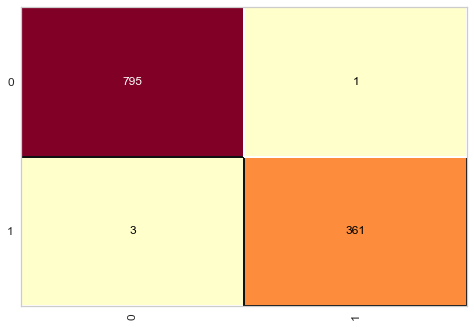

In [69]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(svm_emails)
cm.fit(X_emails_treinamento, y_emails_treinamento)
cm.score(X_emails_teste, y_emails_teste)

In [70]:
print(classification_report(y_emails_teste, previsoes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       796
           1       1.00      0.99      0.99       364

    accuracy                           1.00      1160
   macro avg       1.00      1.00      1.00      1160
weighted avg       1.00      1.00      1.00      1160

